# Experiment Data

### Todo
- Speed plots
- find max speed for continuity checks
- number of visits to arbitrary area
- get the area from exp_state.json
### problems
- undistort_point is not working with the reinforced location
- something looks off with the undistort_data of some sessions (see Test pv20_exp9_20210531_120417)

In [245]:
import os
import sys
os.chdir('/home/tal/dev/reptilearn/system')
sys.path.append('/home/tal/dev/reptilearn/analysis')
import analysis
from pathlib import Path
import pandas as pd
import numpy as np
import undistort
import re
import cv2 as cv
import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import visualize
import bbox
import moviepy.video.io.ffmpeg_tools as ff
import copy
import math
from tqdm.auto import tqdm

## Reload

In [326]:
importlib.reload(analysis)
importlib.reload(undistort)

<module 'undistort' from '/home/tal/dev/reptilearn/system/undistort.py'>

In [232]:
config = analysis.load_config("config")

In [340]:
pd.set_option('display.max_rows', 500)
exps = analysis.list_experiments(config.experiment_data_root)
index = exps.index
exps = pd.concat([exps.reset_index(drop=True), analysis.experiment_stats_df(exps)], axis=1)
exps.index = index

In [341]:
# n most recent experiments
n = 10
exps.sort_index(ascending=False).head(n)

,name,dir,video_count,image_count,csv_count
2021-07-01 12:32:03,pv20_fixcd,/data/reptilearn/experiments/pv20_fixcd_202107...,4,1,6
2021-07-01 08:53:33,pv20_after_yoloerr,/data/reptilearn/experiments/pv20_after_yoloer...,4,1,6
2021-07-01 08:51:45,pv20_after_cam_err,/data/reptilearn/experiments/pv20_after_cam_er...,4,1,6
2021-07-01 08:06:45,pv20_morning_chg_stay_dur,/data/reptilearn/experiments/pv20_morning_chg_...,4,1,6
2021-07-01 07:01:40,pv20_morning,/data/reptilearn/experiments/pv20_morning_2021...,4,1,6
2021-06-30 11:47:12,pv20_long,/data/reptilearn/experiments/pv20_long_2021063...,4,1,6
2021-06-30 10:01:27,d,/data/reptilearn/experiments/d_20210630_100127,4,1,6
2021-06-30 09:50:39,d,/data/reptilearn/experiments/d_20210630_095039,4,1,6
2021-06-30 09:49:54,d,/data/reptilearn/experiments/d_20210630_094954,0,1,2
2021-06-30 09:49:51,d,/data/reptilearn/experiments/d_20210630_094951,4,1,6


In [342]:
pv20 = exps[exps.name.str.startswith('pv20')]

In [343]:
for ts, exp in pv20.iterrows(): print(exp.dir)

/data/reptilearn/experiments/pv20_exp3_20210519_103530
/data/reptilearn/experiments/pv20_exp3_20210519_120403
/data/reptilearn/experiments/pv20_exp3_20210519_125353
/data/reptilearn/experiments/pv20_exp3_20210519_133447
/data/reptilearn/experiments/pv20_exp4_20210520_112511
/data/reptilearn/experiments/pv20_exp6_20210524_092130
/data/reptilearn/experiments/pv20_exp6_20210524_114758
/data/reptilearn/experiments/pv20_exp7_20210527_111256
/data/reptilearn/experiments/pv20_exp6_2_20210527_134505
/data/reptilearn/experiments/pv20_exp8_20210531_101857
/data/reptilearn/experiments/pv20_exp9_20210531_120417
/data/reptilearn/experiments/pv20_exp10_bottom_left_20210602_110241
/data/reptilearn/experiments/pv20_exp10_20210607_102406
/data/reptilearn/experiments/pv20_exp11_20210610_105209
/data/reptilearn/experiments/pv20_exp11_20210614_110403
/data/reptilearn/experiments/pv20_long_20210630_114712
/data/reptilearn/experiments/pv20_morning_20210701_070140
/data/reptilearn/experiments/pv20_morning_ch

# Extract event subclips

In [7]:
def analyze_experiment(exp):
    print(f"Experiment: {exp.name} {exp.dir}")
    info = analysis.load_timestamps(analysis.experiment_info(exp.dir))
    events = analysis.read_event_log(info)
    top_vids_info = analysis.find_src_videos(info, "top")
    
    # Create analysis dir if not exists.
    analysis_dir = exp.dir / "analysis" / "event_clips"
    
    if analysis_dir.exists():
        return
    
    analysis_dir.mkdir(exist_ok=True, parents=True)
    
    # Reward events
    event = 'arena/dispense_reward'
    reward_video_event_df = analysis.create_video_event_df(top_vids_info, events.query("event == @event"))
    analysis.extract_event_clips(reward_video_event_df, analysis_dir, file_prefix='reward')
    
    # old event types 
    old_events = {
        "in_area": events[events.event.str.startswith("learn_exp") & events.value.str.contains("in radius")],
        "out_of_area_wait": events[events.event.str.startswith("learn_exp") & events.value.str.contains("out of radius, waiting")],
        "out_of_area_end_trial": events[events.event.str.startswith("learn_exp") & events.value.str.contains("out of radius, ended")]
    }
    
    # new event types 
    new_events = {
        "in_area": events[events.event.str.contains("in_radius")],
        "out_of_area_wait": events[events.event.str.contains("out_radius")],
        "out_of_area_end_trial": events[events.event.str.contains("logical_trial_ended")]            
    }
    
    pre_secs, post_secs = 5, 5

    for event_list in [old_events, new_events]:
        for event_name, events in event_list.items():
            _ = analysis.extract_event_clips(
                analysis.create_video_event_df(top_vids_info, events), 
                analysis_dir, 
                file_prefix=event_name,
                pre_secs=pre_secs,
                post_secs=post_secs,    
            )
    
for ts, exp in tqdm(pv20.iterrows(), total=len(pv20)):
    analyze_experiment(exp)

  0%|          | 0/15 [00:00<?, ?it/s]

Experiment: 2021-05-19 10:35:30 /data/reptilearn/experiments/pv20_exp3_20210519_103530
Experiment: 2021-05-19 12:04:03 /data/reptilearn/experiments/pv20_exp3_20210519_120403
Experiment: 2021-05-19 12:53:53 /data/reptilearn/experiments/pv20_exp3_20210519_125353
Experiment: 2021-05-19 13:34:47 /data/reptilearn/experiments/pv20_exp3_20210519_133447
Experiment: 2021-05-20 11:25:11 /data/reptilearn/experiments/pv20_exp4_20210520_112511
Experiment: 2021-05-24 09:21:30 /data/reptilearn/experiments/pv20_exp6_20210524_092130
Experiment: 2021-05-24 11:47:58 /data/reptilearn/experiments/pv20_exp6_20210524_114758
Experiment: 2021-05-27 11:12:56 /data/reptilearn/experiments/pv20_exp7_20210527_111256
Experiment: 2021-05-27 13:45:05 /data/reptilearn/experiments/pv20_exp6_2_20210527_134505
Experiment: 2021-05-31 10:18:57 /data/reptilearn/experiments/pv20_exp8_20210531_101857
Experiment: 2021-05-31 12:04:17 /data/reptilearn/experiments/pv20_exp9_20210531_120417
Experiment: 2021-06-02 11:02:41 /data/rep

# Head Position

In [309]:
infos = []
for i, (ts, exp) in enumerate(tqdm(pv20.iterrows(), total=len(pv20))):
    infos.append(analysis.load_timestamps(analysis.experiment_info(exp.dir)))

  0%|          | 0/21 [00:00<?, ?it/s]

In [310]:
cent_dfs = []

for info in tqdm(infos):
    if "head_bbox" in info:
        centroids = analysis.get_head_centroids(info, config.undistort_flir_blackfly_computar)
        cent_df = pd.DataFrame(centroids, columns=["x", "y"])
        cent_dfs.append(cent_df)

  0%|          | 0/21 [00:00<?, ?it/s]

In [289]:
mapping, roi, newcamtx = undistort.get_undistort_mapping(1440, 1080, config.undistort_flir_blackfly_computar)

backgrounds = []

for info in infos:
    imgs = [p for p in info["images"] if "reinforced_area" in p.name]
    if len(imgs) > 0:
        img = cv.imread(str(imgs[0]))
        backgrounds.append(undistort.undistort_image(img, mapping))
    else:
        backgrounds.append(None)

In [290]:
durations = []
for info in infos:
    cams = [list(vid.values())[0] for vid in info["videos"].values()]
    durations.append(sum([cam["duration"] for cam in cams]))

  0%|          | 0/21 [00:00<?, ?it/s]

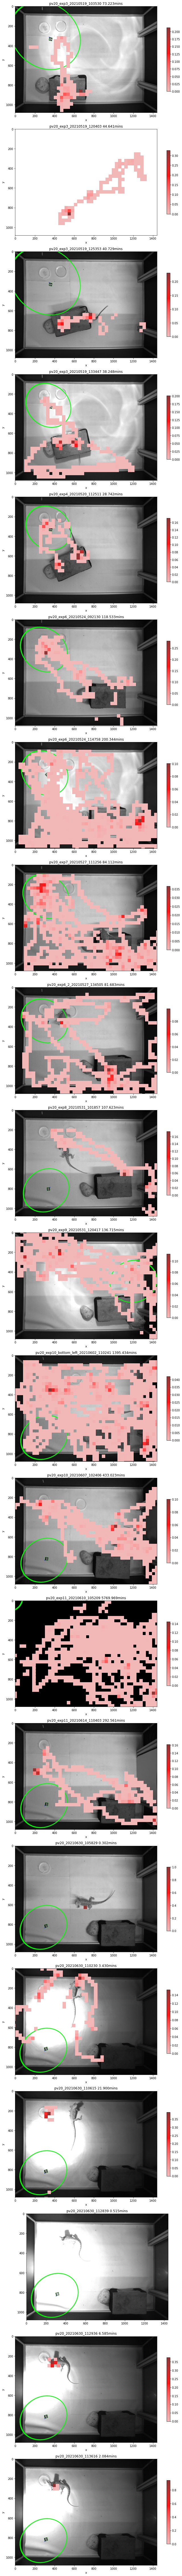

In [291]:
n = pv20.shape[0]
l = 1# math.ceil(math.sqrt(n))
sx = 10
sy = 6
fig, axs = plt.subplots(n//l, l, figsize=(sx*l, sy*n//l))
axs = axs.flatten()

for i, cent_df in enumerate(tqdm(cent_dfs)):
    ax = sns.histplot(cent_df, x="x", y="y", cbar=True, stat="probability", color="red", ax=axs[i],
                     cbar_kws={"shrink": 0.6}, binwidth=32)
    if infos[i]["exp_state"] and "reinforced_location" in infos[i]["exp_state"]:        
        rloc = infos[i]["exp_state"]["reinforced_location"]
        undist_rloc = undistort.undistort_point(rloc, newcamtx, config.undistort_flir_blackfly_computar)
        #print(undist_rloc)
        #ax.add_patch(plt.Circle(undist_rloc, 10, color='r'))
    #ax.scatter(cent_df.x, cent_df.y, alpha=0.1, s=1)
    if backgrounds[i] is not None:
        ax.imshow(backgrounds[i])

    ax.set_title(f"{pv20.iloc[i].dir.name} {durations[i] / np.timedelta64(1, 'm'):.3f}mins")
    ax.axes.set_aspect('equal')
    ax.set_xlim(0, 1440)
    ax.set_ylim(0, 1080)
    ax.invert_yaxis()
    
fig.tight_layout()

# Test pv20_exp9_20210531_120417

In [344]:
exp = pv20.query("name == 'pv20_after_yoloerr'").iloc[0]

In [371]:
info = analysis.load_timestamps(analysis.experiment_info(exp.dir))

In [346]:
info

{'videos': {Timestamp('2021-07-01 08:53:34'): {'back': {'path': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/back_20210701-085334.mp4'),
    'timestamps': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/back_20210701-085334.csv'),
    'frame_count': 730537,
    'duration': numpy.timedelta64(13084084284305,'ns')},
   'left': {'path': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/left_20210701-085334.mp4'),
    'timestamps': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/left_20210701-085334.csv'),
    'frame_count': 730537,
    'duration': numpy.timedelta64(13084079704999,'ns')},
   'top': {'path': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/top_20210701-085334.mp4'),
    'timestamps': PosixPath('/data/reptilearn/experiments/pv20_after_yoloerr_20210701_085333/top_20210701-085334.csv'),
    'frame_count': 730537,
    'duration': numpy.timedelta6

In [349]:
centroids = analysis.get_head_centroids(info, config.undistort_flir_blackfly_computar)
dist_centroids = analysis.get_head_centroids(info, None)

(0.0, 1080.0)

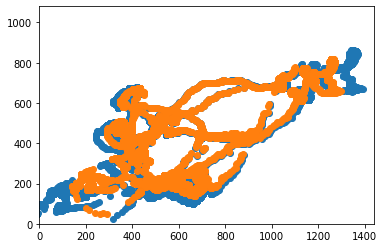

In [350]:
plt.scatter(x=centroids[:, 0], y=centroids[:, 1])
plt.scatter(x=dist_centroids[:, 0], y=dist_centroids[:, 1])
plt.xlim((0, 1440))
plt.ylim((0, 1080))

In [372]:
top_vids_info = analysis.find_src_videos(info, "top")

In [339]:
info["exp_state"]

{'reinforced_location': [1239.75, 527.5]}

In [373]:
events = analysis.read_event_log(info)

In [374]:
es = events.query("event == 'loclearn/entered_area'")
ev_first = es.iloc[0]
ev_last = es.iloc[-1]
events = pd.DataFrame(data=[ev_first, ev_last])

In [375]:
vid_ev_df = analysis.create_video_event_df(top_vids_info, events)

In [376]:
vid_ev_df

,path,frame,timestamp,video_start
0,/data/reptilearn/experiments/pv20_after_yoloer...,600910,2021-07-01 08:52:54.586266112,2021-07-01 05:53:35.059853824
1,/data/reptilearn/experiments/pv20_after_yoloer...,602198,2021-07-01 08:53:17.620288000,2021-07-01 05:53:35.059853824


In [382]:
vid_path = list(top_vids_info.values())[0]["path"]

In [383]:
analysis.extract_clip(vid_path, vid_ev_df.iloc[0].frame - 3600, vid_ev_df.iloc[-1].frame + 3600, "../analysis/july1_consecutive_inout.mp4")

In [ ]:
# add head bbox to this clip!